# Model V2 (Smaller Unit) 

One of the major feedback I received was that the architecture unit is likely too large. In this variation, I'll test using a smaller unit size. 

In [1]:
%load_ext autoreload

%autoreload 2
%reload_ext autoreload

In [2]:
import sys

In [3]:
sys.path.append("..")

In [4]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.style.use('fivethirtyeight')
%matplotlib inline

from tensorflow.keras.applications import NASNetLarge 
from tensorflow.keras.applications.nasnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, model_from_json, load_model
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

import pickle
import os
from timeit import default_timer as timer

import string
import re

Loading custom scripts

In [5]:
from SCRIPT.sequence_generator import *
from SCRIPT.evaluation_tools import *

File locations

In [6]:
flicker_img_dir = '../IMAGES/Flicker/Flicker8k_Dataset'
flicker_text_dir = '../IMAGES/Flicker/labels'
img_dir = '../IMAGES/paintings'

## Feature Extraction
Extract features using NASNetLarge

In [7]:
def feature_extractor(dir_, network = None, ref_dict = None, save = True, path = ''):
    ''' 
    Return a dictionary with filename as keys and extracted features (array) as values
    
    Parameters
    ----------
    dir_ : str
        The directory of images
    network: function, default = VGG16
        A pretrained network to extract features from
    ref_dict: dict, default = None
        If a reference dictionary is given, the output adds to this dictionary.
        Please note that it does not update but add if the key does not exist.
    save: bool, default = True
        If true, it dumps the dictionary using joblib every 1000 runs. ('feature')
    path: str
        Location to dump 'feature' to if save is enabled. By default it saves to the working directory.
        
    '''
    if network: 
        model = network()
    else:
        from tensorflow.keras.applications import VGG16 
        model = VGG16()

    model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
    
    fnames = [x for x in os.listdir(dir_) if x.endswith('.jpg')]
    
    if ref_dict: 
        result = ref_dict
    else:
        result = {}
    
    i = 1
    n = len(fnames)
    
    for fn in fnames:
        ind = fn.split('.')[0]
        if ind not in result: 
            try:
                img = load_img(f'{dir_}/{fn}', target_size = (331, 331))
            except: 
                print(f'failed to load image: {fn}')
                continue
            img = np.expand_dims(img, 0)
            img = preprocess_input(img)
            feature = model.predict(img)
            result[ind] = feature
            print(f'{i}/{n} feature extraction completed')
        i += 1
        
        if save: 
            if i % 1000 == 0: 
                joblib.dump(result, f"{path}/features")
    if save:
        joblib.dump(result, f"{path}/features")
    return result

In [ ]:
# run
features = feature_extractor(flicker_img_dir, NASNetLarge)

In [ ]:
# Saving
#with open('PKL/features.pkl', 'wb') as fp:
#    pickle.dump(features, fp, pickle.HIGHEST_PROTOCOL)

In [9]:
# loading
with open('../PKL/features.pkl', 'rb') as fp:
    features = pickle.load(fp)

extract feature from paintings too

In [ ]:
art_features = feature_extractor(img_dir, NASNetLarge)

In [ ]:
# saving the extracted features
#with open('PKL/art_features.pkl', 'wb') as fp:
#    pickle.dump(art_features, fp, pickle.HIGHEST_PROTOCOL)

In [10]:
# loading
with open('../PKL/art_features.pkl', 'rb') as fp:
    art_features = pickle.load(fp)

## Get Descriptions

In [10]:
# read the description file
with open(f'{flicker_text_dir}/Flickr8k.token.txt', 'r') as fn:
    text = fn.readlines()

In [11]:
# extract only image id and description
pattern = '([0-9a-z_]*)\.jpg.*\\t(.*)\\n'
p = re.compile(pattern)
descriptions_pairs = [p.findall(x)[0] for x in text]

In [11]:
def description_preprocessing(list_of_tuples, n = None):
    '''
    given description pairs, return a dictionary of descriptions
    if n is specified, only select the n number or less descriptions
    per image
    '''
    descriptions = {}

    table_ = str.maketrans('', '', string.punctuation+string.digits)

    for ind, text in list_of_tuples:
        text = text.lower()
        text = str.translate(text, table_)
        text = [x for x in text.split() if len(x) > 1] # remove trailing alphabet
        text = 'seqini ' + ' '.join(text) + ' seqfin' # add initial and ending tokens
        if ind in descriptions:
            descriptions[ind].append(text)
        else:
            descriptions[ind] = [text]
    if n:
        # if n is assigned cap number of description for each image to be n
        for k, v in descriptions.items():
            if len(v) > n:
                descriptions[k] = list(np.random.choice(v, n, replace = False))
    return descriptions

In [12]:
# saving
#with open('PKL/descriptions.pkl', 'wb') as fp:
#    pickle.dump(descriptions, fp)

# loading
with open('../PKL/descriptions.pkl', 'rb') as fp:
    descriptions = pickle.load(fp)

In [13]:
with open('../PKL/img_captions1.pkl', 'rb') as fp:
    img_caption1 = pickle.load(fp)

In [14]:
# remove trailing one characters
img_caption = [(k, v) for k, v in img_caption1.items() if v and (len(v) > 1)]
img_ids = [x[0] for x in img_caption]

## Crossvalidation
Split the photo sets into train/test/val

In [15]:
train_list, test_list = train_test_split(list(descriptions.keys()), test_size = 0.3, random_state = 22)
val_list, test_list = train_test_split(test_list, test_size = 0.5, random_state = 22)

## Model Training
Train model with photo files

In [ ]:
# initialize processor with non-art descriptions and features
processor = sequence_generator(descriptions, features)

In [16]:
# get inputs and output
train_X1, train_X2, train_Y = processor.train_generator(train_list)
val_X1, val_X2, val_Y = processor.validation_generator(val_list)

In [17]:
# get max length and number of vocabularies
max_length = processor.get_max_length()
num_vocab = processor.get_num_vocab()

In [18]:
#first path
in1 = Input(shape = (4032,))
img_layer1 = Dropout(0.5)(in1)
img_layer2 = Dense(64, activation = 'relu')(img_layer1)
# second path
in2 = Input(shape=(max_length,))
text_layer1 = Embedding(num_vocab, 256, mask_zero = True)(in2)
text_layer2 = Dropout(0.5)(text_layer1)
text_layer3 = LSTM(64)(text_layer2)
# outputting
output_layer1 = add([img_layer2, text_layer3])
output_layer2 = Dense(64, activation = 'relu')(output_layer1)
output = Dense(num_vocab, activation = 'softmax')(output_layer2)
# compile model
model = Model(inputs = [in1, in2], outputs = output)
model.compile(loss = 'categorical_crossentropy', 
             optimizer = 'adam')

cp = EarlyStopping(patience = 3, restore_best_weights= True)

# training
start = timer()

history = model.fit([train_X1, train_X2], train_Y, 
                    epochs=10, 
                    validation_data = ([val_X1, val_X2], val_Y),
                    workers = 7, 
                    callbacks = [cp], 
                    verbose = 1
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/10
9046/9046 [==============================] - 385s 43ms/step - loss: 4.5275 - val_loss: 3.9860
Epoch 2/10
9046/9046 [==============================] - 381s 42ms/step - loss: 3.8176 - val_loss: 3.8378
Epoch 3/10
9046/9046 [==============================] - 384s 42ms/step - loss: 3.5958 - val_loss: 3.8111
Epoch 4/10
9046/9046 [==============================] - 382s 42ms/step - loss: 3.4856 - val_loss: 3.8175
Epoch 5/10
9046/9046 [==============================] - 395s 44ms/step - loss: 3.4175 - val_loss: 3.8240
Epoch 6/10
9046/9046 [==============================] - 402s 44ms/step - loss: 3.3746 - val_loss: 3.8439
Total Time Elapsed:  38  minutes  57  seconds


In [19]:
# saving model
model.save('MODEL/small_model_1')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: MODEL/small_model_1\assets


In [ ]:
#loading model
model = load_model('MODEL/small_model')

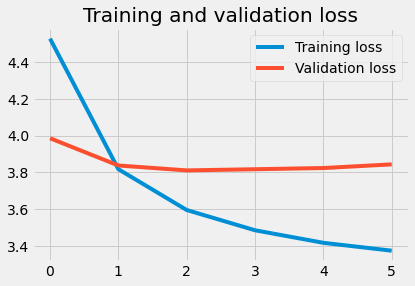

In [20]:
plot_performance(history)

In [21]:
# get the tokenizer
tokenizer = processor.get_tokenizer()

In [ ]:
# testing on photo data
pred_list, score = get_bleu(test_list, features, tokenizer, max_length, model, descriptions)

1-gram BLEU: 0.4223
2-gram BLEU: 0.2288
3-gram BLEU: 0.1477
4-gram BLEU: 0.0604

In [61]:
photo_descriptor = descriptor(features, tokenizer, processor, model, flicker_img_dir)
art_descriptor = descriptor(art_features, tokenizer, processor, model, img_dir)

two dogs are playing in the snow


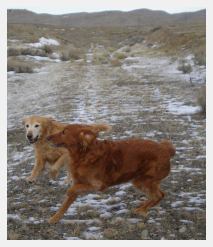

In [67]:
photo_descriptor.test_random_image(test_list)

man in red shirt is standing on the street


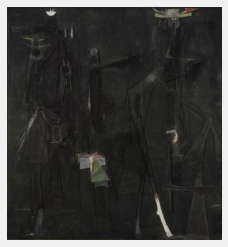

In [74]:
art_descriptor.test_random_image(img_ids)

Clearly it has no way to generalize over artworks. It's pretty standardized description sets. Now I'll try to use the conceptual description sets.

## Conceptual Captions

In [16]:
import joblib 

In [17]:
image_path = '../DATA/IMAGES/Conceptual_Captions'
path = '../PKL'

In [18]:
# get the references (processed in Data Collection section)
cc_ref = joblib.load('../PKL/cc_reference')

### Extract Features

In [ ]:
# get features
features_cc = feature_extractor(image_path, NASNetLarge, ref_dict = features, path = path)

In [45]:
#joblib.dump(features_cc, f"{path}/features")

['../PKL/features']

In [19]:
features_cc = joblib.load(f"{path}/features")

### Preprocess Description
This is a text version of the other description_preprocessing function

In [20]:
def text_preprocessing(text):
    '''
    given description pairs, return a dictionary of descriptions
    if n is specified, only select the n number or less descriptions
    per image
    '''

    table_ = str.maketrans('', '', string.punctuation+string.digits)

    text = text.lower()
    text = str.translate(text, table_)
    text = [x for x in text.split() if len(x) > 1] # remove trailing alphabet
    text = 'seqini ' + ' '.join(text) + ' seqfin' # add initial and ending tokens

    return text

In [21]:
for k, v in cc_ref.items():
    cc_ref[k] = text_preprocessing(v)

## Cross-validation
Let's split this set up.

In [22]:
cc_ref = {str(k): v for k,v in cc_ref.items()}

In [23]:
train_list, test_list = train_test_split(list(cc_ref.keys()), test_size = 0.3, random_state = 22)
val_list, test_list = train_test_split(test_list, test_size = 0.5, random_state = 22)

## Sequence Generator
Let's create a sequence of descriptions.

In [24]:
# initialize processor with non-art descriptions and features
processor = sequence_generator(cc_ref, features_cc)

In [25]:
# get inputs and output
train_X1, train_X2, train_Y = processor.train_generator(train_list)
val_X1, val_X2, val_Y = processor.validation_generator(val_list)

In [26]:
# get max length and number of vocabularies
max_length = processor.get_max_length()
num_vocab = processor.get_num_vocab()

In [ ]:
#first path
in1 = Input(shape = (4032,))
img_layer1 = Dropout(0.5)(in1)
img_layer2 = Dense(64, activation = 'relu')(img_layer1)
# second path
in2 = Input(shape=(max_length,))
text_layer1 = Embedding(num_vocab, 256, mask_zero = True)(in2)
text_layer2 = LSTM(64, return_sequences = True)(text_layer1)
text_layer3 = Dropout(0.5)(text_layer2)
text_layer4 = LSTM(64, return_sequences = True)(text_layer3)
text_layer5 = Dropout(0.5)(text_layer4)
text_layer6 = LSTM(64)(text_layer5)


# outputting
output_layer1 = add([img_layer2, text_layer6])
output_layer2 = Dense(128, activation = 'relu')(output_layer1)
output = Dense(num_vocab, activation = 'softmax')(output_layer2)
# compile model
model = Model(inputs = [in1, in2], outputs = output)
model.compile(loss = 'categorical_crossentropy', 
             optimizer = 'adam')

cp = EarlyStopping(patience = 3, restore_best_weights= True)

# training
start = timer()

history = model.fit([train_X1, train_X2], train_Y, 
                    epochs=10, 
                    validation_data = ([val_X1, val_X2], val_Y),
                    workers = -1, 
                    #callbacks = [cp], 
                    verbose = 1
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/10


In [ ]:
# saving model
model.save(../'MODEL/model_cc')

In [ ]:
model = load_model('MODEL/small_modell_cc')

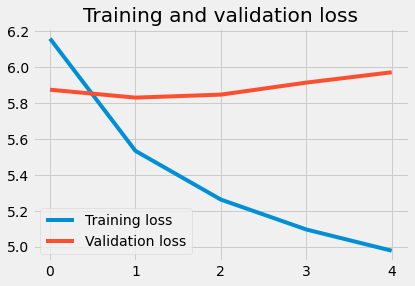

In [60]:
plot_performance(history)

In [61]:
# get the tokenizer
tokenizer = processor.get_tokenizer()

In [ ]:
# testing on photo data
pred_list, score = get_bleu(test_list, features_cc, tokenizer, max_length, model, cc_ref)

1-gram BLEU: 0
2-gram BLEU: 0
3-gram BLEU: 0
4-gram BLEU: 0

In [62]:
photo_descriptor = descriptor(features_cc, tokenizer, processor, model, image_path)
art_descriptor = descriptor(art_features, tokenizer, processor, model, img_dir)

actor and the runway at the premiere


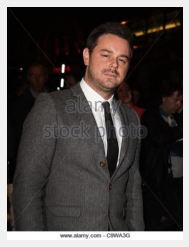

In [65]:
photo_descriptor.test_random_image(test_list)

the white with the background of the background


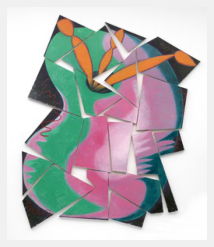

In [68]:
art_descriptor.test_random_image(img_ids)